In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
from os.path import abspath, join
from IPython.display import display, display_markdown
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

CURRENT_DIR = os.path.abspath('')
PARENT = os.path.dirname(CURRENT_DIR)
#PARENT = abspath('')
RUNS = join(PARENT, "runs/")
sys.path.append(PARENT)

In [2]:
from learnable_typewriter.utils.loading import load_pretrained_model
from learnable_typewriter.data.dataloader import collate_fn_pad_to_max

### Inference: 
### As inference we denote the production of the following information out of a given input $x$:
- Reconstruction
- Semantic Segmentation
- Labelling

### Using the `decompositor` module we can produce all the required reconstruction and semantic segmentation information.  
To just obtain reconstruction we can also use the `xp = model.predict_cell_per_cell(x)` function.  
Finally to infer the ground truth characters we use the `trainer.inference(x, xp)` module (where the second argument can be ommitted in the expense of recomputing it internally).

In [3]:
#separer la fonction qui trouve la ligne du dataset
def get_line(loader, idx):
    ds = loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    return x

def inference_from_line(decompositor, x):
    obj = decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]
    rec = to_pil_image(obj['reconstruction'].cpu()[0])
    sgm = to_pil_image(obj['segmentation'].cpu()[0])
    x_image = to_pil_image(x['x'].cpu()[0])
    return x_image, rec, sgm

def inference(trainer, idx):
    ds = trainer.train_loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    print(x.keys())

    obj = trainer.decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]

    #transcribe = trainer.transcribe_unsupervised if trainer.unsupervised else trainer.transcribe
    #gt_txt, pred_txt = '', ''
    #''.join([trainer.transcribe_dataset[t] for t in x['y'][0]]), ''.join([transcribe[t] for t in trainer.inference(x, obj)[0]])
    return gt, rec, sgm, gt_txt, pred_txt

### We also plot the sprites of the model associated with the colors they have on the semantic segmentation. This can help us identify which sprite is being used and whether multiple sprites are overlayed.

In [4]:
def plot_colored_sprites(trainer, n_row=21, n_z=0):
    masks = trainer.model.masks

    colors = torch.Tensor(trainer.decompositor.colors)
    colors = colors.unsqueeze(-1).unsqueeze(-1)  #size (K,3,1,1)
    colors = 1 - colors.expand(masks.size()[0], 3, *masks.size()[2:]) #size (K,3,H_sprite,W_sprite)

    masks = (1 - colors*masks.expand(-1, 3, -1, -1))
    #print(masks.shape)

    pad = n_z * [torch.ones_like(masks[0].unsqueeze(0))]
    masks = torch.cat([masks[i].unsqueeze(0) for i in range(masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding_value=1, padding=2))

In [5]:
def plot_bnw_sprites(trainer, n_row=21, n_z=0):
    masks = trainer.model.masks

    # Reverse the colors of the masks
    reversed_masks = 1 - masks

    #print(masks.shape)

    pad = n_z * [torch.ones_like(reversed_masks[0].unsqueeze(0))]
    masks = torch.cat([reversed_masks[i].unsqueeze(0) for i in range(reversed_masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding_value=1, padding=2))

### Import trainers/pretrained models with load_pretrained_model

### trainer = load_pretrained_model(path=model_path, device=None)

{0: '&', 1: '.', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: ':', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'I', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'i', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'q', 47: 'r', 48: 's', 49: 't', 50: 'u', 51: 'v', 52: 'x', 53: 'y', 54: 'ã', 55: 'ñ', 56: 'õ', 57: '÷', 58: 'ħ', 59: 'ĩ', 60: 'ł', 61: 'ũ', 62: '̃', 63: '̇', 64: '̵', 65: '̾', 66: 'ͣ', 67: 'ͤ', 68: 'ͥ', 69: 'ͦ', 70: 'ͧ', 71: 'ͨ', 72: 'ͫ', 73: 'ͬ', 74: 'ͭ', 75: '᷑', 76: 'ᷝ', 77: 'ᷠ', 78: 'ᷤ', 79: 'ẜ', 80: 'ẽ', 81: '⁊', 82: 'ꝑ', 83: 'ꝓ', 84: 'ꝙ', 85: 'ꝯ', 86: 'ꝰ', 87: 'ꝵ', 88: '\uf1ac'}


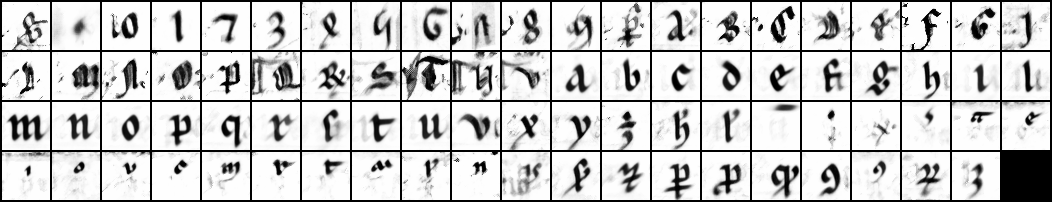

In [16]:
wett_trainer = load_pretrained_model(join(RUNS, 'cremma_masks/wett-mask-0.1-3/2023-11-29_13-40-29'), device=None)
display(plot_bnw_sprites(wett_trainer))

Text(0.5, 1.0, 'd_wett')

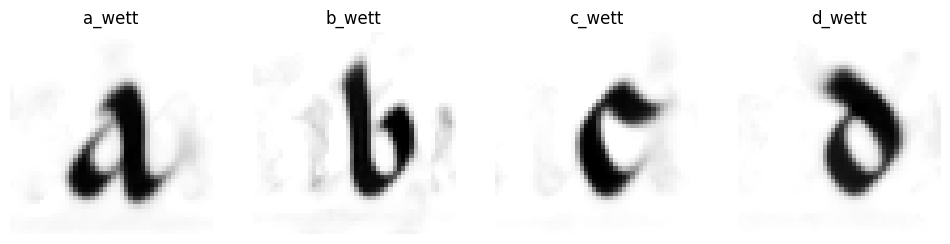

In [103]:
### print a sprite separately

wett_masks = wett_trainer.model.masks
wett_masks = 1 - wett_masks

a_wett = wett_masks[32].squeeze().detach().cpu().numpy()  # Convert to a NumPy array
b_wett = wett_masks[33].squeeze().detach().cpu().numpy()  
c_wett = wett_masks[34].squeeze().detach().cpu().numpy()  
d_wett = wett_masks[35].squeeze().detach().cpu().numpy()  


fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].imshow(a_wett, cmap='gray')
ax[0].axis('off')
ax[0].set_title('a_wett')
ax[1].imshow(b_wett, cmap='gray')
ax[1].axis('off')
ax[1].set_title('b_wett')
ax[2].imshow(c_wett, cmap='gray')
ax[2].axis('off')
ax[2].set_title('c_wett')
ax[3].imshow(d_wett, cmap='gray')
ax[3].axis('off')
ax[3].set_title('d_wett')

### Comparing sprites - drafted with Mathieu

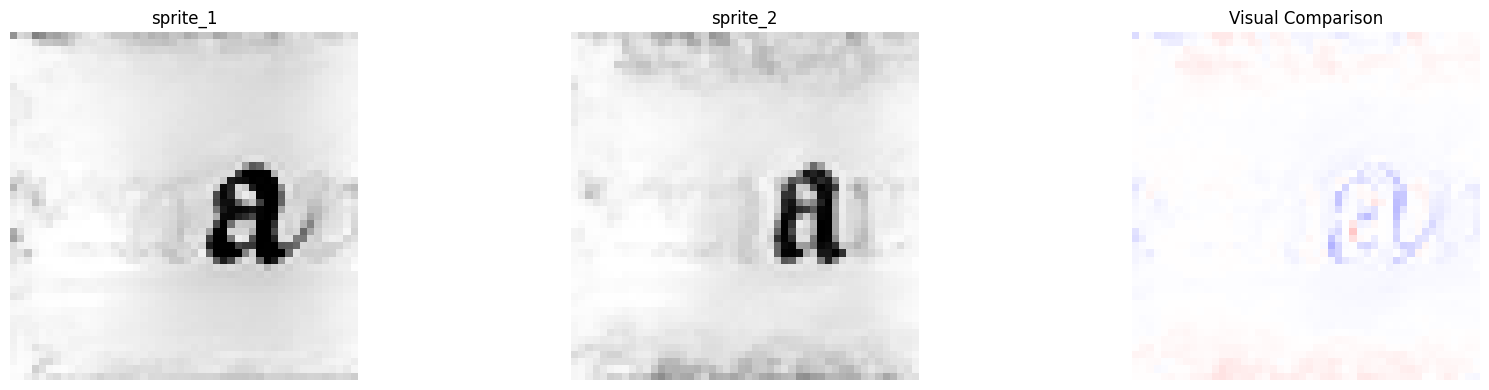

In [26]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def substract_images(image1, image2, axes, opacity=0.5):
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

    # Overlay image2 on top of image1 within the existing subplot
    axes[2].imshow(image1.astype(float) - image2.astype(float), cmap=cmap, vmin=-255, vmax=255, alpha=opacity)
    axes[2].axis('off')  # Hide the axes
    axes[2].set_title('Visual Comparison')

# Example usage:
folder1 = '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-05/Arras-861/sprites/final'
folder2 = '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-05/btv1b6000108b/sprites/final'
character = '28'

# Construct the file paths for the images.
image1_path = os.path.join(folder1, f"{character}.png")
image2_path = os.path.join(folder2, f"{character}.png")

# Load the images.
image1 = np.array(Image.open(image1_path))
image2 = np.array(Image.open(image2_path))

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot folder1
axes[0].imshow(image1, cmap='gray')
axes[0].axis('off')
axes[0].set_title('sprite_1')

# Plot folder2
axes[1].imshow(image2, cmap='gray')
axes[1].axis('off')
axes[1].set_title('sprite_2')

# Overlay image2 on top of image1
substract_images(image1, image2, axes, opacity=0.4)

# Display the images
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_l2_norm(image1, image2):
    difference = image1.astype(float) - image2.astype(float)
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

def substract_images(image1, image2, opacity=0.5):
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

    # Overlay image2 on top of image1 within the existing subplot
    result_image = image1.astype(float) - image2.astype(float)
    result_image = np.clip(result_image, -255, 255)  # Clip values to stay within the colormap range
    result_image = (result_image + 255) / 510  # Normalize values to [0, 1] for RGBA colormap
    result_image = np.uint8(cmap(result_image) * 255)  # Apply colormap and convert to uint8

    return result_image

def concatenate_images(images, output_path):
    # Create a new blank image with the desired dimensions and a transparent background
    result_width = sum(image.shape[1] for image in images)
    result_height = max(image.shape[0] for image in images)
    result = Image.new("RGBA", (result_width, result_height), (255, 255, 255, 0))

    # Paste images onto the blank image
    x_offset = 0
    for image in images:
        result.paste(Image.fromarray(image), (x_offset, 0))
        x_offset += image.shape[1]

    # Save the result with a unique name in the output folder
    result.save(output_path)

def create_comparison_image(folder1, folder2, character_range, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    l2_norm_data = []

    for character in character_range:
        # Construct the file paths for the images.
        image1_path = os.path.join(folder1, f"{character}.png")
        image2_path = os.path.join(folder2, f"{character}.png")

        # Load the images.
        image1 = np.array(Image.open(image1_path))
        image2 = np.array(Image.open(image2_path))

        # Overlay image2 on top of image1
        result_image = substract_images(image1, image2, opacity=0.4)

        # Concatenate images horizontally and save the result
        output_path = os.path.join(output_folder, f'north_Arras_{character}.png')
        concatenate_images([image1, image2, result_image], output_path)
        
        # Extract sample names from the output_path
        filename = os.path.splitext(os.path.basename(output_path))[0]
        sample_parts = filename.split('_')
        sample1 = f"{sample_parts[0]}_{sample_parts[2]}.png"
        sample2 = f"{sample_parts[1]}_{sample_parts[2]}.png"

        # Calculate L2 norm and add to DataFrame
        l2_norm = calculate_l2_norm(image1, image2)
        l2_norm_data.append([sample1, sample2, round(l2_norm, 3)])

    # Create a DataFrame from L2 norm data
    df = pd.DataFrame(l2_norm_data, columns=["Sample 1", "Sample 2", "L2 Difference"])
    #return df

    # Save DataFrame as image
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    plt.savefig(os.path.join(output_folder, 'l2_norm_dataframe.png'), bbox_inches='tight')
    plt.close()

# Example usage:
folder1 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-21-12/Northern_Textualis/sprites/final/'
folder2 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/Arras-861/sprites/final'#, '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8433319z/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8447298r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b52515037r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b84473026/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90590259/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90615126/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b100361755/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b525068331/sprites/final/']
character_range = range(30, 55)
output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/comp_results/north_Arras(north)/'

create_comparison_image(folder1, folder2, character_range, output_folder)

In [65]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_l2_norm(image1, image2):
    difference = image1.astype(float) - image2.astype(float)
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

def substract_images(image1, image2, opacity=0.5):
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

    # Overlay image2 on top of image1 within the existing subplot
    result_image = image1.astype(float) - image2.astype(float)
    result_image = np.clip(result_image, -255, 255)  # Clip values to stay within the colormap range
    result_image = (result_image + 255) / 510  # Normalize values to [0, 1] for RGBA colormap
    result_image = np.uint8(cmap(result_image) * 255)  # Apply colormap and convert to uint8

    return result_image

def create_comparison_df(folder1, folder2_list, character_range, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    all_results_data = []

    for folder2 in folder2_list:
        l2_norm_data = []

        for character in character_range:
            # Construct the file paths for the images.
            image1_path = os.path.join(folder1, f"{character}.png")
            image2_path = os.path.join(folder2, f"{character}.png")

            # Load the images.
            image1 = np.array(Image.open(image1_path))
            image1 = 255 - image1
            image2 = np.array(Image.open(image2_path))

            # Overlay image2 on top of image1
            result_image = substract_images(image1, image2, opacity=0.4)

            # Extract sample names from the image paths
            sample1 = os.path.splitext(os.path.basename(image1_path))[0]
            sample2 = os.path.splitext(os.path.basename(image2_path))[0]

            # Calculate L2 norm and add to DataFrame
            l2_norm = calculate_l2_norm(image1, image2)
            l2_norm_data.extend([sample1, sample2, round(l2_norm, 3)])

        # Append the L2 norm data for the current folder2 as additional columns
        all_results_data.append(l2_norm_data)

    # Create a DataFrame from all L2 norm data
    columns = ["Sample 1", "Sample 2", "L2 Difference"] * len(character_range)
    all_results_df = pd.DataFrame(all_results_data, columns=columns)

    # Save the combined DataFrame as an image
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.table(cellText=all_results_df.values, colLabels=all_results_df.columns, cellLoc='center', loc='center')
    plt.savefig(os.path.join(output_folder, 'all_results_l2_norm_dataframe.png'), bbox_inches='tight')
    plt.close()

    return all_results_df

# Example usage:
character_range = range(30, 55)
folder1 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-18-12/Northern_Textualis/sprites/final/'
folder2_list = ['/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/Arras-861/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8433319z/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8447298r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b52515037r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b84473026/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90590259/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90615126/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b100361755/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b525068331/sprites/final/']
output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/comp_results/all/'

create_comparison_df(folder1, folder2_list, character_range, output_folder)

,Sample 1,Sample 2,L2 Difference,Sample 1,Sample 2,L2 Difference,Sample 1,Sample 2,L2 Difference,Sample 1,...,L2 Difference,Sample 1,Sample 2,L2 Difference,Sample 1,Sample 2,L2 Difference,Sample 1,Sample 2,L2 Difference
0,30,30,419.377,31,31,700.428,32,32,928.828,33,...,3505.144,52,52,995.200,53,53,1242.247,54,54,1068.509
1,30,30,1128.435,31,31,1028.418,32,32,1081.308,33,...,3033.948,52,52,1125.779,53,53,1299.273,54,54,1352.730
2,30,30,671.818,31,31,767.571,32,32,974.703,33,...,3042.056,52,52,1018.310,53,53,1188.348,54,54,874.963
3,30,30,992.669,31,31,1095.980,32,32,1042.690,33,...,2179.832,52,52,1063.179,53,53,1374.103,54,54,932.506
4,30,30,729.173,31,31,775.765,32,32,924.500,33,...,2927.819,52,52,1021.431,53,53,1216.498,54,54,1012.807
5,30,30,1147.269,31,31,1129.979,32,32,1198.860,33,...,3204.552,52,52,1521.647,53,53,1557.340,54,54,1510.055
6,30,30,968.276,31,31,1046.888,32,32,1105.002,33,...,3103.717,52,52,1279.082,53,53,1376.603,54,54,1385.442
7,30,30,1347.391,31,31,1364.376,32,32,1276.473,33,...,3142.733,52,52,1591.306,53,53,1423.056,54,54,1868.797
8,30,30,677.394,31,31,713.937,32,32,968.017,33,...,2845.415,52,52,1015.100,53,53,1225.795,54,54,1039.248


# Use this one for cropped images, L2 loss df

In [2]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_l2_norm(image1, image2):
    difference = image1.astype(float) - image2.astype(float)
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

def substract_images(image1, image2, opacity=0.5):
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'maroon'], N=256) #couleurs différentes pour chaque échantillon

    # Overlay image2 on top of image1 within the existing subplot
    result_image = image1.astype(float) - image2.astype(float)
    result_image = np.clip(result_image, -255, 255)  # Clip values to stay within the colormap range
    result_image = (result_image + 255) / 510  # Normalize values to [0, 1] for RGBA colormap
    result_image = np.uint8(cmap(result_image) * 255)  # Apply colormap and convert to uint8

    return result_image

def concatenate_images(images, output_path):
    # Create a new blank image with the desired dimensions and a transparent background
    result_width = sum(image.shape[1] for image in images)
    result_height = max(image.shape[0] for image in images)
    result = Image.new("RGBA", (result_width, result_height), (255, 255, 255, 0))

    # Paste images onto the blank image
    x_offset = 0
    for image in images:
        result.paste(Image.fromarray(image), (x_offset, 0))
        x_offset += image.shape[1]

    # Save the result with a unique name in the output folder
    result.save(output_path)

def create_comparison_image(folder1, folder2, character_range, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    l2_norm_data = []

    for character in character_range:
        # Construct the file paths for the images.
        image1_path = os.path.join(folder1, f"{character}.png")
        image2_path = os.path.join(folder2, f"{character}.png")

        # Load the images.
        image1 = np.array(Image.open(image1_path))
        image2 = np.array(Image.open(image2_path))
        h, w = image1.shape
        crop_size = 26
        start_h = (h - crop_size) // 2
        start_w = w - crop_size  # Set starting index for the middle-right part

        image1 = image1[start_h:start_h + crop_size, start_w:]
        image2  = image2[start_h:start_h + crop_size, start_w:]


        # Overlay image2 on top of image1
        result_image = substract_images(image1, image2, opacity=0.4)

        # Concatenate images horizontally and save the result
        output_path = os.path.join(output_folder, f'south_btv1b8433319z_{character}.png')
        concatenate_images([image1, image2, result_image], output_path)
        
        # Extract sample names from the output_path
        filename = os.path.splitext(os.path.basename(output_path))[0]
        sample_parts = filename.split('_')
        sample1 = f"{sample_parts[0]}_{sample_parts[2]}.png"
        sample2 = f"{sample_parts[1]}_{sample_parts[2]}.png"

        # Calculate L2 norm and add to DataFrame
        l2_norm = calculate_l2_norm(image1, image2)
        l2_norm_data.append([sample1, sample2, round(l2_norm, 3)])

    # Create a DataFrame from L2 norm data
    df = pd.DataFrame(l2_norm_data, columns=["Sample 1", "Sample 2", "L2 Difference"])
    #use /home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-350epochs-eval-fix/comp_results/char_occurences.csv to add nb of occurences per char - same index 
    #return df

    # Save DataFrame as image
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    plt.savefig(os.path.join(output_folder, 'l2_norm_dataframe.png'), bbox_inches='tight')
    plt.close()

# Example usage:
folder1 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs-eval-fix/Southern_Textualis/sprites/final/'
folder2 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-350epochs-eval-fix/btv1b8433319z/sprites/final'#, '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8433319z/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8447298r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b52515037r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b84473026/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90590259/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90615126/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b100361755/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b525068331/sprites/final/']
character_range = range(30, 51)
output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-350epochs-eval-fix/comp_results/south_btv1b8433319z(south)/'

create_comparison_image(folder1, folder2, character_range, output_folder)            

# Use this one for cropped images, L2 loss df and  character occurences per ms! 

In [39]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_l2_norm(image1, image2):
    difference = image1.astype(float) - image2.astype(float)
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

def substract_images(image1, image2, opacity=0.5):
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

    result_image = image1.astype(float) - image2.astype(float)
    result_image = np.clip(result_image, -255, 255)
    result_image = (result_image + 255) / 510
    result_image = np.uint8(cmap(result_image) * 255)

    return result_image

def concatenate_images(images, output_path):
    result_width = sum(image.shape[1] for image in images)
    result_height = max(image.shape[0] for image in images)
    result = Image.new("RGBA", (result_width, result_height), (255, 255, 255, 0))

    x_offset = 0
    for image in images:
        result.paste(Image.fromarray(image), (x_offset, 0))
        x_offset += image.shape[1]

    result.save(output_path)

def create_comparison_image(folder1, folder2, character_range, output_folder, csv_path):
    os.makedirs(output_folder, exist_ok=True)

    l2_norm_data = []

    # Read the CSV file
    df_occurrences = pd.read_csv(csv_path, index_col=0)
    #print(df_occurrences)

    for character in character_range:
        # Get the folder ID from folder2
        folder_id = folder2.split('/')[-4]

        # Check if folder_id exists in the DataFrame columns
        if folder_id in df_occurrences.columns:
            print(folder_id)
            # Get occurrences for the specific character and folder ID
            occurrences = df_occurrences.loc[character, folder_id]
        else:
             #Set occurrences to a default value if folder_id is not present
            occurrences = None

        image1_path = os.path.join(folder1, f"{character}.png")
        image2_path = os.path.join(folder2, f"{character}.png")

        image1 = np.array(Image.open(image1_path))
        image2 = np.array(Image.open(image2_path))
        #h, w = image1.shape
        #crop_size = 26
        #start_h = (h - crop_size) // 2
        #start_w = w - crop_size
        #image1 = image1[start_h:start_h + crop_size, start_w:]
        #image2 = image2[start_h:start_h + crop_size, start_w:]

        result_image = substract_images(image1, image2, opacity=0.4)
        output_path = os.path.join(output_folder, f'north_btv1b84473026_{character}.png')
        concatenate_images([image1, image2, result_image], output_path)

        filename = os.path.splitext(os.path.basename(output_path))[0]
        sample_parts = filename.split('_')
        sample1 = f"{sample_parts[0]}_{sample_parts[2]}.png"
        sample2 = f"{sample_parts[1]}_{sample_parts[2]}.png"

        l2_norm = calculate_l2_norm(image1, image2)
        l2_norm_data.append([sample1, sample2, round(l2_norm, 3), occurrences])

    df = pd.DataFrame(l2_norm_data, columns=["Sample 1", "Sample 2", "L2 Difference", "Occurrences"])

    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    plt.savefig(os.path.join(output_folder, 'l2_norm_dataframe.png'), bbox_inches='tight')
    plt.close()

# Example usage:
folder1 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Northern_Textualis/sprites/final/'
folder2 = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b84473026/sprites/final/'#, '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8433319z/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b8447298r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b52515037r/sprites/final','/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b84473026/sprites/final', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90590259/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b90615126/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b100361755/sprites/final/', '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta/btv1b525068331/sprites/final/']
character_range = range(30, 51)
output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/north_btv1b84473026(north)/'
csv_path = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/char_occurences.csv'

create_comparison_image(folder1, folder2, character_range, output_folder, csv_path)

btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026
btv1b84473026


# Graphs for distances 

# Individuals

In [44]:
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define your folder paths
folder_1 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Southern_Textualis/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Northern_Textualis/sprites/349/'
]

folder_2 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/Arras-861/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8433319z/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8447298r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b52515037r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b84473026/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90590259/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90615126/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b100361755/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b525068331/sprites/final'
    
]

output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/test_graphs/'

# Load JSON mapping of character index to label
json_path = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/sprites/transcribe.json'
with open(json_path) as json_file:
    character_mapping = json.load(json_file)

# Custom character range
character_range = list(range(30, 37)) + list(range(38, 40)) + list(range(44, 51))

# Function to calculate L2 difference between two images
def calculate_l2_norm(image1, image2):
    w, h = image1.size
    crop_size = 26
    start_h = (h - crop_size) // 2
    start_w = w - crop_size
    image1_cropped = image1.crop((start_w, start_h, w, h))
    
    w, h = image2.size
    start_w = w - crop_size
    image2_cropped = image2.crop((start_w, start_h, w, h))

    array1 = np.array(image1_cropped).astype(float)
    array2 = np.array(image2_cropped).astype(float)
    difference = array1 - array2
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm


# Function to create a graph with x, y coordinates and L2 differences
def plot_l2_differences(folder_1_paths, folder_2_paths, output_folder):
    for folder_2_path in folder_2_paths:
        folder_comp_id = folder_2_path.split('/')[-3]

        # Create a new plot
        plt.figure()

        all_l2_diff_southern = []
        all_l2_diff_northern = []

        for character in character_range:
            northern_image_path = os.path.join(folder_1_paths[1], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            northern_image = Image.open(northern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_northern = calculate_l2_norm(northern_image, folder_2_image)
            all_l2_diff_northern.append(l2_difference_northern)

            southern_image_path = os.path.join(folder_1_paths[0], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            southern_image = Image.open(southern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_southern = calculate_l2_norm(southern_image, folder_2_image)
            all_l2_diff_southern.append(l2_difference_southern)
            
        plt.plot([0, max(all_l2_diff_southern + all_l2_diff_northern)], [0, max(all_l2_diff_southern + all_l2_diff_northern)], linestyle='--', color='gray')


        # Plot the points for Southern and Northern differences
        plt.scatter(all_l2_diff_southern, all_l2_diff_northern, label=f'{folder_comp_id}', alpha=0.5)

        for character, x, y in zip(character_range, all_l2_diff_southern, all_l2_diff_northern):
            plt.text(x, y, character_mapping.get(str(character), str(character)), fontsize=8, ha='right', va='bottom')

        plt.xlabel('Southern Textualis')
        plt.ylabel('Northern Textualis')
        plt.title(f'L2 Distances between {folder_comp_id} and North/South Textualis')
        plt.legend()
        plt.grid(True)
        
        
        # Set the same starting value for axes
        max_val = max(max(all_l2_diff_southern), max(all_l2_diff_northern))
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)


        # Save the plot
        output_plot_path = os.path.join(output_folder, f'l2_differences_plot_{folder_comp_id}.png')
        plt.savefig(output_plot_path)
        plt.close()

# Call the function with your folder paths
plot_l2_differences(folder_1, folder_2, output_folder)

# Here plotting them together

In [45]:
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define your folder paths
folder_1 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Southern_Textualis/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Northern_Textualis/sprites/349/'
]

folder_2 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/Arras-861/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8433319z/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8447298r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b52515037r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b84473026/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90590259/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90615126/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b100361755/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b525068331/sprites/final'
    
]

output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/test_graphs/'

# Load JSON mapping of character index to label
json_path = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/sprites/transcribe.json'
with open(json_path) as json_file:
    character_mapping = json.load(json_file)

# Custom character range
character_range = list(range(30, 37)) + list(range(38, 40)) + list(range(44, 51))

# Function to calculate L2 difference between two images
def calculate_l2_norm(image1, image2):
    w, h = image1.size
    crop_size = 26
    start_h = (h - crop_size) // 2
    start_w = w - crop_size
    image1_cropped = image1.crop((start_w, start_h, w, h))
    
    w, h = image2.size
    start_w = w - crop_size
    image2_cropped = image2.crop((start_w, start_h, w, h))

    array1 = np.array(image1_cropped).astype(float)
    array2 = np.array(image2_cropped).astype(float)
    difference = array1 - array2
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

# Function to create a graph with x, y coordinates and L2 differences
def plot_l2_differences(folder_1_paths, folder_2_paths, output_folder):
    # Create a new figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    
    #colors = plt.cm.jet(np.linspace(0, 1, len(folder_2_paths)))

    for i, folder_2_path in enumerate(folder_2_paths):
        folder_comp_id = folder_2_path.split('/')[-3]

        all_l2_diff_southern = []
        all_l2_diff_northern = []

        for character in character_range:
            northern_image_path = os.path.join(folder_1_paths[1], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            northern_image = Image.open(northern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_northern = calculate_l2_norm(northern_image, folder_2_image)
            all_l2_diff_northern.append(l2_difference_northern)

            southern_image_path = os.path.join(folder_1_paths[0], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            southern_image = Image.open(southern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_southern = calculate_l2_norm(southern_image, folder_2_image)
            all_l2_diff_southern.append(l2_difference_southern)

        # Plot the points for Southern and Northern differences with different colors
        axs[i//3, i%3].scatter(all_l2_diff_southern, all_l2_diff_northern, label=f'{folder_comp_id}', alpha=0.5)#, color=colors[i])
        axs[i//3, i%3].set_xlabel('Southern Textualis')
        axs[i//3, i%3].set_ylabel('Northern Textualis')
        axs[i//3, i%3].set_title(f'L2 Diff {folder_comp_id} - North/South Textualis')
        axs[i//3, i%3].legend()
        axs[i//3, i%3].grid(True)

        # Plot diagonal line
        axs[i//3, i%3].plot([0, max(all_l2_diff_southern + all_l2_diff_northern)], [0, max(all_l2_diff_southern + all_l2_diff_northern)], linestyle='--', color='gray')
        
        # Set the same starting value for axes
        max_val = max(max(all_l2_diff_southern), max(all_l2_diff_northern))
        axs[i//3, i%3].set_xlim(0, max_val)
        axs[i//3, i%3].set_ylim(0, max_val)

        # Increase border size
        axs[i//3, i%3].margins(0.1)

        # Add character text for every subplot
        for character, x, y in zip(character_range, all_l2_diff_southern, all_l2_diff_northern):
            axs[i//3, i%3].text(x, y, character_mapping.get(str(character), str(character)), fontsize=8, ha='right', va='bottom')

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    output_plot_path = os.path.join(output_folder, 'l2_differences_plots.png')
    plt.savefig(output_plot_path)
    plt.close()

# Call the function with your folder paths
plot_l2_differences(folder_1, folder_2, output_folder)

# Here I'm trying the intensity thing

In [47]:
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define your folder paths
folder_1 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Southern_Textualis/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-g_theta-350epochs/Northern_Textualis/sprites/349/'
]

folder_2 = [
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/Arras-861/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8433319z/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b8447298r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b52515037r/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b84473026/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90590259/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b90615126/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b100361755/sprites/final',
    '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/btv1b525068331/sprites/final'
    
]

output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/test_graphs/'

# Load JSON mapping of character index to label
json_path = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/sprites/transcribe.json'
with open(json_path) as json_file:
    character_mapping = json.load(json_file)

csv_path = '/home/vlachoum/learnable-scriber/finetune_runs/south-north-ft/south-north-individual-g_theta_350epochs/comp_results/char_occurences.csv'

    
# Custom character range
character_range = list(range(30, 39)) + list(range(41, 51))
#character_range = range(30,51)

char_occurrences_df = pd.read_csv(csv_path, index_col=0)
char_occurrences_df = char_occurrences_df.loc[list(range(30, 39)) + list(range(41, 51))]
display(char_occurrences_df)

# Function to calculate L2 difference between two images
def calculate_l2_norm(image1, image2):
    w, h = image1.size
    crop_size = 26
    start_h = (h - crop_size) // 2
    start_w = w - crop_size
    image1_cropped = image1.crop((start_w, start_h, w, h))
    
    w, h = image2.size
    start_w = w - crop_size
    image2_cropped = image2.crop((start_w, start_h, w, h))

    array1 = np.array(image1_cropped).astype(float)
    array2 = np.array(image2_cropped).astype(float)
    difference = array1 - array2
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

# Function to create a graph with x, y coordinates and L2 differences
def plot_l2_differences(folder_1_paths, folder_2_paths, output_folder, char_occurrences_df):
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    for i, folder_2_path in enumerate(folder_2_paths):
        folder_comp_id = folder_2_path.split('/')[-3]

        all_l2_diff_southern = []
        all_l2_diff_northern = []
        
        char_occurrences = char_occurrences_df[folder_comp_id]

        for character in character_range:
            northern_image_path = os.path.join(folder_1_paths[1], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            northern_image = Image.open(northern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_northern = calculate_l2_norm(northern_image, folder_2_image)
            all_l2_diff_northern.append(l2_difference_northern)

            southern_image_path = os.path.join(folder_1_paths[0], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            southern_image = Image.open(southern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_southern = calculate_l2_norm(southern_image, folder_2_image)
            all_l2_diff_southern.append(l2_difference_southern)

        # Plot the points with color intensity based on character occurrences
        scatter = axs[i//3, i%3].scatter(all_l2_diff_southern, all_l2_diff_northern, c=char_occurrences, cmap='viridis', alpha=0.5)
        axs[i//3, i%3].set_xlabel('Southern Textualis')
        axs[i//3, i%3].set_ylabel('Northern Textualis')
        axs[i//3, i%3].set_title(f'L2  {folder_comp_id} - North/South')
        axs[i//3, i%3].legend()
        axs[i//3, i%3].grid(True)

        # Plot diagonal line
        axs[i//3, i%3].plot([0, max(all_l2_diff_southern + all_l2_diff_northern)], [0, max(all_l2_diff_southern + all_l2_diff_northern)], linestyle='--', color='gray')

        # Set the same starting value for axes
        max_val = max(max(all_l2_diff_southern), max(all_l2_diff_northern))
        axs[i//3, i%3].set_xlim(0, max_val)
        axs[i//3, i%3].set_ylim(0, max_val)
        
        # Increase border size
        axs[i//3, i%3].margins(0.1)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axs[i//3, i%3])

        # Add character text for every subplot
        for character, x, y in zip(character_range, all_l2_diff_southern, all_l2_diff_northern):
            axs[i//3, i%3].text(x, y, character_mapping.get(str(character), str(character)), fontsize=8, ha='right', va='bottom')

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    output_plot_path = os.path.join(output_folder, 'l2_differences_plots_intensity.png')
    plt.savefig(output_plot_path)
    plt.close()

# Call the function with your folder paths
plot_l2_differences(folder_1, folder_2, output_folder, char_occurrences_df)

,Arras-861,btv1b8447298r,btv1b90590259,btv1b100361755,btv1b8433319z,btv1b84473026,btv1b90615126,btv1b525068331,btv1b52515037r
30,966.0,183.0,100.0,586.0,874.0,84.0,141.0,82.0,445.0
31,164.0,18.0,8.0,57.0,54.0,10.0,33.0,18.0,24.0
32,420.0,90.0,45.0,146.0,415.0,32.0,66.0,39.0,107.0
33,375.0,87.0,37.0,282.0,297.0,31.0,61.0,44.0,245.0
34,1102.0,485.0,214.0,808.0,865.0,217.0,367.0,207.0,460.0
35,111.0,46.0,13.0,74.0,88.0,10.0,24.0,12.0,41.0
36,102.0,45.0,12.0,83.0,118.0,14.0,33.0,15.0,83.0
37,92.0,24.0,9.0,41.0,99.0,15.0,18.0,6.0,23.0
38,1457.0,239.0,171.0,331.0,807.0,88.0,202.0,72.0,324.0
41,436.0,151.0,81.0,382.0,525.0,52.0,137.0,92.0,310.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

## crop and concatenate a range of chars for a specific list of folders 

In [61]:
import os
import numpy as np
from PIL import Image
import cv2

def create_crop_image(folders, character_range, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for index, folder in enumerate(folders):
        # Load and crop images for each character in the range
        cropped_images = []
        for character in character_range:
            image_path = os.path.join(folder, f"{character}.png")
            
            # Check if the image file exists for the current character
            if os.path.exists(image_path):
                image = np.array(Image.open(image_path))
                h, w = image.shape
                crop_size = 26
                start_h = (h - crop_size) // 2
                start_w = w - crop_size  # Set starting index for the middle-right part
                cropped_image = image[start_h:start_h + crop_size, start_w:]
                cropped_images.append(cropped_image)
            else:
                print(f"Warning: Image not found for character {character} in folder {folder}")

        # Concatenate the cropped images
        if cropped_images:
            concatenated_image = np.concatenate(cropped_images, axis=1)

            # Save the concatenated image
            output_path = os.path.join(output_folder, f'{index}_concatenated.png')
            cv2.imwrite(output_path, concatenated_image)
        else:
            print(f"Warning: No images found for any characters in folder {folder}")

# Example usage
folders = [
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/btv1b6000108b/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/btv1b525068331/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/btv1b8455783p/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/btv1b9058181z/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/btv1b84260044/sprites/final/',
    '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/baseline/'
]
character_range = ['28', '29', '30', '31']
output_folder = '/home/vlachoum/learnable-scriber/finetune_runs/textualis-ft/textualis-g_theta-350epochs/comp_results/cipl/idiographs'

create_crop_image(folders, character_range, output_folder)